In [1]:
# import tensorflow as tf
# sess = tf.Session()
import itertools
import keras
from keras import backend as K
# K.set_session(sess)
import h5py

from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

# import pandas 

from process_data import *
from model_saving import load_model
import os
from n_gram_lm import *

import kenlm

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3720226247761778183
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 8728132026121933749
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [3]:
# Problem parameters
max_input_len = 500
max_label_len = 180
max_ratio = 7
n_energies = 20
n_phonemes = 39+1 # 39 phonemes, 1 blank
blank_idx = n_phonemes - 1
blank_idx = n_phonemes - 1

In [4]:
model_name = "densenet_phon_nospace_b3.l5.f128.k7.relu"

In [5]:
model, highest_epoch = load_model(model_name, mode="best")

Loading model densenet_phon_nospace_b3.l5.f128.k7.relu
Compiling...
Looking for weight files with mode "best"
File densenet_phon_nospace_b3.l5.f128.k7.relu-8-41.4200063095.hdf5 contains weights after 8 epochs achieving validation loss: 41.4200063095
File densenet_phon_nospace_b3.l5.f128.k7.relu-1-63.4348470576.hdf5 contains weights after 1 epochs achieving validation loss: 63.4348470576
File densenet_phon_nospace_b3.l5.f128.k7.relu-3-53.978602621.hdf5 contains weights after 3 epochs achieving validation loss: 53.978602621
File densenet_phon_nospace_b3.l5.f128.k7.relu-4-47.3478324621.hdf5 contains weights after 4 epochs achieving validation loss: 47.3478324621
File densenet_phon_nospace_b3.l5.f128.k7.relu-0-81.0895705597.hdf5 contains weights after 0 epochs achieving validation loss: 81.0895705597
File densenet_phon_nospace_b3.l5.f128.k7.relu-3-48.3601631543.hdf5 contains weights after 3 epochs achieving validation loss: 48.3601631543
File densenet_phon_nospace_b3.l5.f128.k7.relu-10-40.

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
mfccs (InputLayer)               (None, 500, 20)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 500, 128)      18048       mfccs[0][0]                      
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 500, 128)      512         conv1d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 500, 128)      0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [6]:
inputs, outputs, ids = get_test_data(n_phonemes, max_label_len, max_input_len)

# print inputs_valid.keys()
X = inputs["mfccs"]
input_lengths= inputs["input_lens"]
y= inputs["labels"]
label_lengths= inputs["label_lens"]


In [7]:
print np.median(input_lengths)

156.0


In [8]:

ctc_costs, phoneme_probs = model.predict(inputs)
phoneme_probs.shape

(2836, 500, 40)

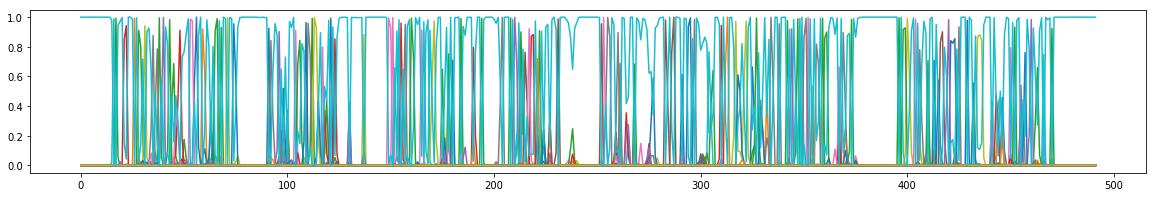

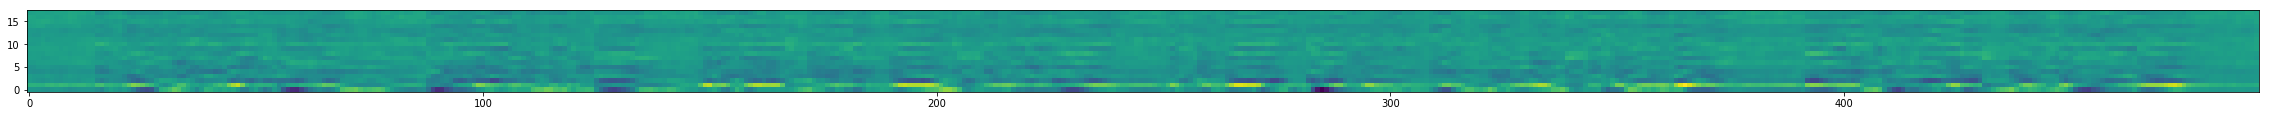

In [28]:
checking_idx = 2
sample_id = ids[checking_idx]

sample_probs = phoneme_probs[checking_idx]
sample_input_length = input_lengths[checking_idx]
sample_label_length = label_lengths[checking_idx]
sample_X = X[checking_idx]

plt.figure(figsize=(20,3))
plt.plot(sample_probs[:sample_input_length]);
fig, ax = plt.subplots(figsize=(40,100))
mfcc_data= np.swapaxes(sample_X[:input_lengths[checking_idx], 2:], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest' , origin='lower')


In [31]:
# print "Sample id: {}".format(sample_id)
print
# Try the argmax acoustic-only decoder
print "Argmax phonemes:"
phonemes = interpret_probs(sample_probs[:sample_input_length], ignore_blanks = False)
print "".join([x for x in phonemes if x!="-"])
# Print the 'actual' text
print

# set_names = ["train-clean-100", "train-clean-360", "train-other-500"]

# print label_filename
csv_file = open("asset/data/preprocess/meta/test.csv", "r")
reader = csv.reader(csv_file, delimiter = ",")
print sample_id
for row in reader:
#     print row[0]
    if row[0] == sample_id:
        label = [int(x) for x in row[1:]]
        actual_text = code_to_phonemes(label)
csv_file.close()            
        
print "Actual text :"
print "".join(actual_text)
# 6319-275224-0019.flac

print "Normalized loss:"
print ctc_costs[checking_idx]


Argmax phonemes:
DHAHFAENSIYZAHVDHAHNUWPLAEKNAHSTAAROWLEYIHNTRAHSTIHNTUWAWSBIHKAOZDHEYIHKSAHAHTAHFEYZAHVDHAHHHYUWMAHTMAYWIHCHRIYEYLWAYTLIYDHAHFERSTSEHNCHERIYZAHVDHAHKRIHSCHAHNIHRAHAHNDIHZNAATHHOWLIYEHTSEYNGKTIHNAWTOWNDHEY

2961-960-0006.flac
Actual text :
DHAHFAENSIYZAHVDHAHNIYOWPLEYTAHNAHSTSAAROWNLIYIHNTRAHSTIHNGTUWAHSBIHKAOZDHEYIHGZIHBIHTAHFEYZAHVDHAHHHYUWMAHNMAYNDWIHCHPRIHVEYLDWAYDLIYIHNDHAHFERSTSEHNCHERIYZAHVDHAHKRIHSCHAHNEHRAHAHNDIHZNAATHHOWLIYIHKSTIHNGKTIHNAWEROWNDEY
Normalized loss:
[ 122.76714325]


In [ ]:
libri_test_path = "asset/data/LibriSpeech/test-clean"
VCTK_test_path = "asset/data/VCTK/"

In [21]:

arpabet = nltk.corpus.cmudict.dict()
def strip_num(phone):
    if phone[-1].isdigit():
        return phone[:-1]
    else:
        return phone

phone_word = [(map(strip_num, v[0]), k) for (k, v) in arpabet.items()]

rev_dict = {}
for (k,v) in phone_word:
    prop_key = " ".join(k)
    if prop_key in rev_dict:
        rev_dict[prop_key] += [v]
    else:
        rev_dict[prop_key] = [v]
phoneme_list = interpret_code(y_valid[checking_idx, :label_lengths_valid[checking_idx]])
print "".join(phoneme_list)
# print " ".join([rev_dict[" ".join(g)][-1] for k,g in itertools.groupby(phoneme_list,lambda x:x==" ") if not k])

NameError: name 'y_valid' is not defined

In [34]:
# Define the mini keras model to get the cost from a subset of the probs
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args # reorder the args because the order is shit
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

phoneme_probs = Input(shape=(max_input_len, n_phonemes), name="phoneme_probs")
input_length = Input(name='input_length',shape=[1], dtype='int64')
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
label_length = Input(name='label_length', shape=[1], dtype='int64')
ctc = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([phoneme_probs, labels, input_length, label_length])
cost_getter = Model(inputs=[phoneme_probs, labels, input_length, label_length], outputs=[ctc])
cost_getter.summary()
sgd = Adam(lr=0.02, clipnorm=5)
cost_getter.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

# Wrap the keras prediction nicely
# Take a list of phonemes, a list of probabilitity distributions over phonemes of length max_input_length
# and the number of time steps of the probability distribution to compute the log probability of the phonemes from.
def acoustic_score(phoneme_list, phoneme_probs, t):
    inputs = {"phoneme_probs": phoneme_probs,
              "input_length": t, # Only consider this many time steps 
              "the_labels": code_phonemes(phoneme_list),
              "label_length": len(phoneme_list)}
    ctc = cost_getter.predict(inputs) # this should be the negative log probability
    return ctc


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
phoneme_probs (InputLayer)       (None, 500, 40)       0                                            
____________________________________________________________________________________________________
the_labels (InputLayer)          (None, 180)           0                                            
____________________________________________________________________________________________________
input_length (InputLayer)        (None, 1)             0                                            
____________________________________________________________________________________________________
label_length (InputLayer)        (None, 1)             0                                            
___________________________________________________________________________________________

In [35]:
cmudict = nltk.corpus.cmudict.dict()
language = cmudict.keys()

In [22]:
lang_model = kenlm.Model('language_model_dat/3-gram-words.arpa')

language_score = lambda x: lang_model.score(x, eos=False, bos=False )


In [23]:

def beam_search_word(phoneme_probs, input_length, language_score, alpha, beta, n_paths, step_size):
    print "Starting beam search with input of length {} ...".format(input_length)
    # Initialize the candidate-score dict with the empty string
    candidates = {"":0.}
    # Iterate over input timesteps and possibly grow the tree at each
    for i in range(input_length/step_size):
        t = i * step_size
        if i % input_length/10 == 0:
            print "Reached t = {}".format(t)
        # Get the n_paths best paths
        
        top_candidates = dict(sorted(candidates.items(), key= lambda x: x[1])[:n_paths])
        print "Found top {} candidates".format(n_paths)
        # Check each path for whether growing it will improve its score
        for s,score in top_candidates.items():
            # Check every extension allowed by the lm
            print "Checking extensions of \"{}\" which has current score {}".format(s, score)
            for word in language:
                s_new_list = [u for u in s.split(" ") if u!=""] +[word]
                s_new = s+" "+word
                # If the extension has already been evaluated, don't rescore it
                if s_new in candidates.keys():
                    continue
                # Each word can have several pronunciations, so add up all the acoustic scores for them
#                 new_score = sum([acoustic_score(phon_list, phoneme_probs, t) \
#                              for phon_list in obtain_phonemes(s_new_list)])
                print s_new_list
                new_phonemes = obtain_phonemes(s_new_list, cmudict)[:-1] # remove the space at the end
                print new_phonemes
                # Add the language score and the length bonus
                new_score = acoustic_score(new_phonemes, phoneme_probs, t) \
                            + alpha*language_score(s_new) \
                            + beta*len(s_new_list)
                # Add the new sentence to the candidates if it is better than its parent
                if new_score >= score:
                    candidates[s_new] = new_score
    return candidates
                    

In [48]:
n_paths = 100
alpha = 1.25
beta = 0.1            
step_size = 5
candidates = beam_search_word(sample_probs, sample_input_length, language_score, alpha, beta, n_paths, step_size)

Starting beam search with input of length 258 ...
Reached t = 0
Found top 100 candidates
Checking extensions of "" which has current score 0.0
[u'fawn']
[u'F', u'AO', u'N']


AttributeError: 'list' object has no attribute 'shape'